*** 
# **M1MAO -- M1 MFA FES 2021/2022 -- Université Paris-Saclay**
***


In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.tri as tri
import math
import numpy.random as rd
import scipy.sparse as sp
import scipy.sparse.linalg as splinalg


# TP 6 : Éléments finis en 2D

Dans ce TP, on s'intéresse à la résolution approchée du problème aux limites suivant, avec conditions aux limites de Neumann homogène :

$$
(PN)\left\{\begin{aligned}
&-\Delta u+u=f,\; \textrm{dans }\Omega,\\
&\frac{\partial u}{\partial n}=0,\; \textrm{sur }\partial\Omega
\end{aligned}
\right.
$$
où $f:\overline{\Omega}\longrightarrow\mathbb{R}$ est une fonction de classe $\mathcal{C}^2$ donnée et $\Omega$ est un ouvert régulier de $\mathbb{R}^2$ donné. 

La formulation variationnelle du problème $(P)$ est donnée par   
\begin{equation*}
(PNv)\ \ \ 
\begin{cases}
u\in V  \,\textrm{tel que}\\
a(v,u)=L(v),\ \,\forall\ v\in V ,
\end{cases}
\end{equation*}
où $V=H^1(\Omega)$, 
$$a(u,v)=\int_{\Omega} \nabla u\nabla v+\int_{\Omega}uv$$   
et 
$$ L(v)=\int_{\Omega}fv.$$  

Soit $\mathcal T_h$ une triangulation du domaine $\Omega$ et $V_h$ l'approximation de $H^1(\Omega)$ par des éléments finis $\mathbb P_1$ associés à la triangulation $\mathcal T_h.$ On note $\{T_N\}_{N=1,\dots,N_t}\ $ les triangles de $\mathcal T_h,$ $\{S_i\}_{i=1,\dots,N_h}\ $ les sommets de la triangulation et $\{\phi_i\}_{i=1,\dots,N_h}\ $ les fonctions de la base de $V_h$ définies par $\phi_i(S_j)=\delta_{ij},\ i,j=1,\dots,N_h.$ 

Le problème discret consiste alors à chercher $u_h\in V_h$ tel que 
$$
(PNv_h)\ \ \ \ \ \ \ \ \ a(u_h,\phi_i)=l(\phi_i),\ \,\forall\ i=1,\dots,N_h. 
$$





**Q1)** Soit $u_h=\displaystyle{\sum_{i=1}^{{N_h}}u_i\phi_i}.$ Montrer que $u_h$ est solution de $(PNv_h)$ si et seulement si le vecteur $U=(u_1,\dots,u_{N_h})$ est solution d'un système linéaire 
$$
KU+MU=F,
$$
où $K$ et $M$ sont les matrices de $\mathcal{M}^{N_h\times N_h}(\mathbb{R})$ définies par $K_{i,j}=\int_{\Omega}\nabla\phi_i\cdot\nabla\phi_j,$ $M_{i,j}=\int_{\Omega}\phi_i\phi_j,$ et où $F$ est le vecteur de $\mathbb{R}^{N_h}$ défini par $F_i=\int_{\Omega}f\phi_i.$ 



**Maillage de $\Omega$**

Dans un premier temps on considère $\Omega$ le carré $[0,2]\times[0,2].$ 

La triangulation $\mathcal T_h$ de $\Omega$ est représentée par deux matrices. La première, que l'on appellera $T$, contient la liste des triangles. Il s'agit d'une matrice de taille $N_t\times3$ que, dans chaque ligne $N$, contient l'indice $i$ de chaque sommet $S_i$ appartenant au triangle $T_N.$ La deuxième, que l'on appellera $TabSom,$ contient les coordonnées de chaque sommet de la triangulation. C'est une matrice de taille $N_h\times2$ que, dans chaque ligne $i$ contient les coordonnées du sommet $S_i.$ 
Le code suivant crée le maillage et ces matrices.

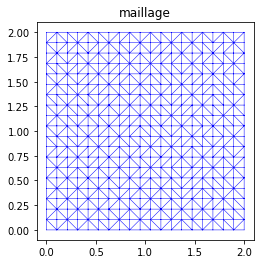

In [47]:

Nx=18
Ny=18

x_m=0.
x_M=2.
y_m=0.
y_M=2.

x=np.linspace(x_m,x_M,Nx+2)
y=np.linspace(y_m,y_M,Ny+2)

X,Y=np.meshgrid(x,y)

X=X.flatten()
Y=Y.flatten()

X=np.vstack((X,Y)).T

triang = tri.Triangulation(X[:,0],X[:,1])

# Tableau avec noeuds des triangles
T = triang.triangles


NTri=np.shape(T)[0]
NSom=np.shape(triang.x)[0]

#Tableau avec coordonnes des noeuds
TabSom=np.zeros([NSom,2])
TabSom[:,0]=triang.x
TabSom[:,1]=triang.y


plt.figure(1)
plt.gca().set_aspect('equal')
plt.triplot(X[:,0],X[:,1],T, 'b-', lw=0.5)
plt.title('maillage')

plt.show()




**Les matrices élémentaires : la matrice de masse**

Pour construire la matrice de masse M et de rigidité K, on commence par définir des matrices élémentaires qui permettent, localement sur un triangle $T_N$ de noeuds $S_{k_1},\ S_{k_2}$ et $S_{k_3},$ de calculer 
$$
 \int_{T_N}\phi_{k_i}\phi_{k_j} 
$$
pour $i,\ j=1,2,3.$ Ces intégrales vont contribuer respectivement à l'élément  $M_{k_i,k_j}$ dela matrice globale.

**Q2)** Construire une fonction `M_elem(S1,S2,S3)`  calculant la matrice de masse  sur un triangle $T$ de sommets $\mathcal{S1}=(x_1,y_1),\ \mathcal{S2}=(x_2,y_2)$ et $\mathcal{S3}=(x_3,y_3).$  
Pour calculer la matrice de masse élémentaire sur le triangle $T,$ on peut utiliser les formules ci-dessous. 
Les fonctions de base associées à chaque sommet de $T$ sont localement données par
$$
\lambda_1(x,y)=\frac{1}{D}(y_{23}(x-x_3)-x_{23}(y-y_3)),\ \ \ \lambda_2(x,y)=\frac{1}{D}(y_{31}(x-x_1)-x_{31}(y-y_1)),\ \ \ \lambda_3(x,y)=\frac{1}{D}(y_{12}(x-x_2)-x_{12}(y-y_2)),
$$
où $x_{ij}=x_i-x_j,\ y_{ij}=y_i-y_j$ et $D=x_{23}y_{31}-x_{31}y_{23}.$ $|D|$ est égal à deux fois la surface du triangle.

Pour $k_1,\ k_2,\ k_3\in\{0,1,2\},$ on a 
$$
\int_{T}\lambda_1^{k_1}\lambda_2^{k_2}\lambda_3^{k_3}=\frac{k_1!k_2!k_3!}{(k_1+k_2+k_3+2)!}|D|.
$$

In [48]:
def M_elem(S1,S2,S3):
    x1 = S1[0]
    y1 = S1[1]
    x2 = S2[0] 
    y2 = S2[1]
    x3 = S3[0]
    y3 = S3[1]
    D = ((x2-x3)*(y3-y1) - (y2-y3)*(x3-x1))
    M=(1.*np.abs(D)/24)*np.ones([3,3])
    M[range(3),range(3)]=1.*np.abs(D)/12
    return M



**Assemblage de la matrice $M$**

Dans cette partie on met en oeuvre un algorithme pour construire la matrice $M$. Pour ce faire on remarque que, par exemple, 
$$
M_{i,j}=\sum_{N=1}^{N_t}\int_{T_N}\phi_i\phi_j=\sum_{N : S_i,S_j\in T_N}\int_{T_N}\phi_i\phi_j.
$$

L'algoritme de construction des matrices consiste alors à faire la boucle suivante :

    Pour N= 1...Nt
         Détérmination des sommets S_I1, S_I2 et S_I3 du triangle T_N
         Calcul des matrices élémentaires associées au triangle T_N
             Pour i=1..3
                Pour j=1...3 
                    M(Ii,Ij)=M(Ii,Ij)+M_elem(i,j)

**Q3)** Compléter dans le programme l'assemblage de la matrice M

In [49]:
M = np.zeros([NSom,NSom])

for N in range(0,NTri):
    S1=TabSom[T[N,0],:]
    S2=TabSom[T[N,1],:]
    S3=TabSom[T[N,2],:]

    Mel=M_elem(S1, S2, S3)

    for i in range(0,3): 
        I = T[N,i]
        for j in range(0,3): 
            J = T[N,j]
            M[I,J] = M[I,J] + Mel[i,j]




**La matrice de rigidité**

**Q4)** En utilisant les fonctions de base "locales" associées à chaque sommet de $T$ montrer que
$$ \int_T\langle\nabla\lambda_i|\nabla\lambda_j\rangle=\dfrac{1}{2|D|}\langle\nabla\lambda_i|\nabla\lambda_j\rangle $$
**Q5)** Écrire une fonction `K_elem` calculantla matrice de rigidité  sur un triangle $T$ de sommets $\mathcal{S1}=(x_1,y_1),\ \mathcal{S2}=(x_2,y_2)$ et $\mathcal{S3}=(x_3,y_3).$ 


In [50]:
def K_elem(S1,S2,S3):
    x1 = S1[0]
    y1 = S1[1]
    x2 = S2[0] 
    y2 = S2[1]
    x3 = S3[0]
    y3 = S3[1]
    norm = np.zeros([3, 2])
    norm[0, :] = np.array([y2-y3, x3-x2])
    norm[1, :] = np.array([y3-y1, x1-x3])
    norm[2, :] = np.array([y1-y2, x2-x1])
    D = ((x2-x1)*(y3-y1) - (y2-y1)*(x3-x1))
    K = np.zeros([3,3])
    for i in range(3):
        for j in range(3):
            K[i,j] = np.dot(norm[i,:],norm[j,:])
    return (1./(2*abs(D)))*K


**Q6)** Coder l'assemblage de la matrice de rigidité K

In [51]:
K = np.zeros([NSom,NSom])

for N in range(0,NTri):
    S1=TabSom[T[N,0],:]
    S2=TabSom[T[N,1],:]
    S3=TabSom[T[N,2],:]

    Kel=K_elem(S1, S2, S3)

    for i in range(0,3): 
        I = T[N,i]
        for j in range(0,3): 
            J = T[N,j]
            K[I,J] = K[I,J] + Kel[i,j]




**Calcul du second membre $F.$**

On peut calculer exactement les composantes $F_i$ du vecteur $F$ ou approcher ses valeurs en utilisant par exemple des formules de quadrature.

Ici on fait le choix de remplacer $f$ par son interpolé $\mathbb P_1$ aux points du maillage, *i.e.* on approche $f$ par la fonction $\displaystyle{\sum_{i=1}^{N_h}f(S_i)\phi_i}.$ 

**Q7)** En approchant $f$ par son interpolé, donner une approximation du second membre $F$ faisant intervenir la matrice de masse.  

On admet que cette approximation ne change pas l'approximation par éléments finis du problème. 

**Validation : calcul d'une solution connue**

On considère $f$ tel que la fonction
$$
u(x,y)=\cos(\pi x)\cos(2\pi y)
$$
est solution du problème $(PNv)$ dans $\Omega=[0,2]\times[0,2].$ 

**Q8)** Construire dans le programme une fonction $f(x,y)$ définissant le second membre $f$ et calculer l'approximation du vecteur $F$ obtenue comme expliqué dessus. Calculer le vecteur $U$ des coefficients de la solution approchée donnée par la méthode des élements finis et utiliser le code suivant pour la visualiser.

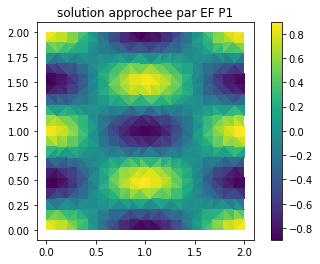

In [52]:
F = np.zeros([NSom,1])

def f(x,y):
    return (1.+5*np.pi**2)*np.cos(np.pi*x)*np.cos(2*np.pi*y)

def uex(x,y):
    return np.cos(np.pi*x)*np.cos(2*np.pi*y)
 
ff=f(TabSom[:,0],TabSom[:,1])
   
F=np.dot(M,ff)


A=M+K

u=np.linalg.solve(A,F)
ue=uex(TabSom[:,0],TabSom[:,1])
plt.figure(2)
plt.gca().set_aspect('equal')
#plt.tripcolor(triang, U, shading='flat')
plt.tripcolor(triang.x,triang.y,triang.triangles, u, shading='flat')
plt.colorbar()
plt.title('solution approchee par EF P1')

plt.show()


**Q9)** Visualiser la solution exacte et calculer l'erreur en norme $H^1$

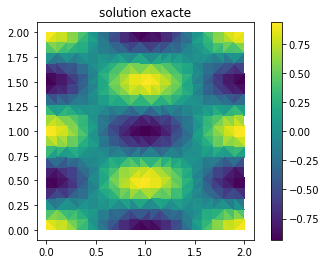

Erreur en norme H^1=0.604892


In [53]:
plt.figure(3)
plt.gca().set_aspect('equal')
#plt.tripcolor(triang, U, shading='flat')
plt.tripcolor(triang.x,triang.y,triang.triangles, ue, shading='flat')
plt.colorbar()
plt.title('solution exacte')

plt.show()

er=u-ue
errH1=np.sqrt(np.dot(er,np.dot(A,er)))
print("Erreur en norme H^1=%g"%(errH1))


### (Bonus) l'ordre de convergence en norme $H^1$

**Q1)**  Écrire une fonction `triangulation(Nx,Ny,x_m,x_M,y_m,y_M)` qui retournera une matrice `T` contenante  la liste des triangles et une matrice  `TabSom` qui contient les coordonnées de chaque sommet de la triangulation. 

In [54]:
def triangulation(Nx,Ny,x_m,x_M,y_m,y_M):
    x=np.linspace(x_m,x_M,Nx+2)
    y=np.linspace(y_m,y_M,Ny+2)

    X,Y=np.meshgrid(x,y)

    X=X.flatten()
    Y=Y.flatten()

    X=np.vstack((X,Y)).T

    triang = tri.Triangulation(X[:,0],X[:,1])

    # Tableau avec noeuds des triangles
    T = triang.triangles


    #NTri=np.shape(T)[0]
    NSom=np.shape(triang.x)[0]

    #Tableau avec coordonnes des noeuds
    TabSom=np.zeros([NSom,2])
    TabSom[:,0]=triang.x
    TabSom[:,1]=triang.y
    
    return T, TabSom
    


**Q2)** Écrire une fonction `masse_et_rigidite(TabSom,T)` retournant les matrices de masse et rigidité. 

In [55]:
def masse_et_rigidite(TabSom,T):
    NSom = TabSom.shape[0]
    NTri = T.shape[0]
    K = np.zeros([NSom,NSom])
    M = np.zeros([NSom,NSom])
    for N in range(0,NTri):
        S1=TabSom[T[N,0],:]
        S2=TabSom[T[N,1],:]
        S3=TabSom[T[N,2],:]
        Kel=K_elem(S1, S2, S3)
        Mel=M_elem(S1, S2, S3)
        for i in range(0,3): 
            I = T[N,i]
            for j in range(0,3): 
                J = T[N,j]
                M[I,J] = M[I,J] + Mel[i,j]
                K[I,J] = K[I,J] + Kel[i,j]
    return M,K


**Q3)** On considère $\Omega$ le carré $[0,2]\times[0,2]$ et les données de la question **Q8**, calculer pour `Nx=Ny=[20,30,40,50,60]` l'erreur en norme $H^1$ et l'afficher en échelle logaritmique en fonction de la taille  $h$ de la triangulation (dans ce cas le diamètre d'un triangle $T_N$).


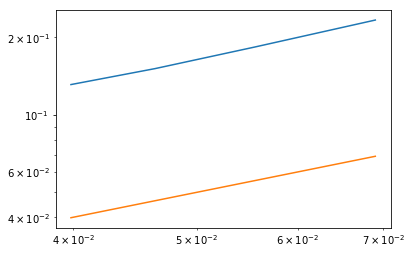

In [56]:
Nx=[40,50,60,70]
x_m=0.
x_M=2.
y_m=0.
y_M=2.
err=[]
dh=[]
for i in Nx:
    h=np.sqrt(2)*2/(i+1)
    dh.append(h)
    T,TabSom=triangulation(i,i,x_m,x_M,y_m,y_M)
    M,K=masse_et_rigidite(TabSom,T)
    ff=f(TabSom[:,0],TabSom[:,1])
    F=np.dot(M,ff)
    A=M+K
    u=np.linalg.solve(A,F)
    ue=uex(TabSom[:,0],TabSom[:,1])
    er=u-ue
    errH1=np.sqrt(np.dot(er,np.dot(A,er)))
    err.append(errH1)

plt.plot(dh,err)
plt.plot(dh,np.array(dh))
plt.xscale('log')
plt.yscale('log')
    

    
    

